# Prepare data

First we will create a dictionary of Semcor words, and look at them and their frequencies.


Next, we want to create a dataset of a subsample of semcor. We want to remove the most common and least common words

We also want to limit to 30 examples of each sense of a word.

So, we begin iterating through a randomly shuffled semcor. For each word, we throw it out if it is too frequent or too infreqient. Then, we look at the senses.



At the end, we store a list of all of the words we've collected. For each item in the dictionary, we should know:
- the number of tokens
- the wordnet senses
- a list of the semcor sentence indices of the tokens of each word. 


In [1]:
from nltk.corpus import semcor
from nltk.tree import Tree
import itertools
import random
import pandas as pd
import torch
from bert import *
import csv
#from nltk.corpus.reader import wordnet
from nltk.corpus import wordnet as wn
import inflect

from scipy.stats import spearmanr, pearsonr
import re

bert = BERTBase()


INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/tmp01lc7pnj
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 3

In [165]:
p = inflect.engine()
p.plural("mouse")

'mice'

In [3]:
"""
load semcor stats
"""

# uncomment for whole dataset
sents = semcor.sents()
tagged_sents = semcor.tagged_sents( tag = ' sem ' )
words = semcor.words()


##########
# DEBUG ONLY
############

# tagged_sents = semcor.tagged_sents( tag = ' sem ' )[:20]
# sents = semcor.sents()[:20]
# words = semcor.words()[1000]





In [4]:
"""
create a dictionary of tokens in semcor with counts
"""
from collections import Counter

semcor_lexicon = Counter()

for word in words:
    word = word.lower()
    semcor_lexicon[word] +=1

semcor_lexicon

Counter({'the': 49074,
         'fulton': 14,
         'county': 125,
         'grand': 40,
         'jury': 55,
         'said': 1412,
         'friday': 59,
         'an': 2648,
         'investigation': 39,
         'of': 24954,
         'atlanta': 27,
         "'s": 4037,
         'recent': 123,
         'primary': 65,
         'election': 72,
         'produced': 62,
         '``': 6169,
         'no': 1520,
         'evidence': 133,
         "''": 6097,
         'that': 7541,
         'any': 957,
         'irregularities': 7,
         'took': 293,
         'place': 422,
         '.': 34716,
         'further': 149,
         'in': 15012,
         'term': 52,
         'end': 265,
         'presentments': 1,
         'city': 345,
         'executive': 37,
         'committee': 116,
         ',': 40614,
         'which': 2495,
         'had': 3534,
         'over-all': 19,
         'charge': 69,
         'deserves': 13,
         'praise': 12,
         'and': 19960,
         'thanks':

In [5]:
"""
little script on semcor_lexicon to see where we should cut off most and least frequent
"""

print(semcor_lexicon.most_common(200))
n = 30000
print(semcor_lexicon.most_common()[:-n-1:-1])

# we want to keep words with a count < 600

# and with a count greater than > 10 (which is knocking off the l)

[('the', 49074), (',', 40614), ('.', 34716), ('of', 24954), ('and', 19960), ('to', 18089), ('a', 16399), ('in', 15012), ('that', 7541), ('is', 7228), ('he', 6812), ('was', 6773), ('for', 6574), ('it', 6375), ('``', 6169), ("''", 6097), ('with', 5145), ('as', 4953), ('on', 4818), ('his', 4604), ('be', 4552), ("'s", 4037), ('at', 3765), ('by', 3688), ('this', 3639), ('i', 3589), ('had', 3534), ('not', 3247), ('are', 3171), ('but', 3076), ('from', 3032), ('-', 2967), ('or', 2917), ('have', 2811), ('they', 2759), ('an', 2648), ('you', 2629), ('which', 2495), ('one', 2359), ('were', 2319), ('all', 2121), ('would', 2052), ('there', 2019), (';', 1997), ('we', 1972), ('she', 1968), ('their', 1926), ('her', 1909), ('has', 1857), ('him', 1801), ('?', 1715), ('been', 1714), ('when', 1629), ('will', 1611), ('more', 1592), ('who', 1580), ('if', 1545), (')', 1535), ('(', 1524), ('no', 1520), ('out', 1488), ('said', 1412), ("n't", 1407), ('so', 1384), ('can', 1379), ('what', 1377), ('do', 1358), ('up

In [6]:
"""
get basic semcor stats
"""
print("number of sentences:")
print(len(sents))
print("number of tokens:")
print(len(words))
print("number of types:")
print(len(semcor_lexicon))

number of sentences:
37176
number of tokens:
820411
number of types:
38642


Then, for each word, we find all of the tokens of that word in the corpus, and use the model to predict features for that word.



In [26]:
"""
first, index the sentences in the dataset
"""
# just retrieve all the sentences
#sents = semcor.sents()


#for sent in sents:
#      print(sent.num)
#      print(sent)
#      index = int(sent.num)
#      semcor_indexer[index] = sent

"""
now we have an index of sentences, where the index corresponds to the n value in semcor, and the sentence is a list of string tokens
"""



"""
you can also just use sents  and get the sentence directly....
like sents[32]
why dont you just do that silly


just have to note that the sent.num attribute is 1-indexed while the corpus is 0 indexed
"""
print(sents[0]) # ['The', 'petition', 'listed', 'the', 'mayor', "'s", 'occupation', 'as', '``', 'attorney', "''", 'and', 'his', 'age', 'as', '71', '.']
print(sents[0].num)


[Tree('DT', ['The']), Tree(Lemma('group.n.01.group'), [Tree('NE', [Tree('NNP', ['Fulton', 'County', 'Grand', 'Jury'])])]), Tree(Lemma('state.v.01.say'), [Tree('VB', ['said'])]), Tree(Lemma('friday.n.01.Friday'), [Tree('NN', ['Friday'])]), Tree('DT', ['an']), Tree(Lemma('probe.n.01.investigation'), [Tree('NN', ['investigation'])]), Tree('IN', ['of']), Tree(Lemma('atlanta.n.01.Atlanta'), [Tree('NN', ['Atlanta'])]), Tree('POS', ["'s"]), Tree(Lemma('late.s.03.recent'), [Tree('JJ', ['recent'])]), Tree(Lemma('primary.n.01.primary_election'), [Tree('NN', ['primary', 'election'])]), Tree(Lemma('produce.v.04.produce'), [Tree('VB', ['produced'])]), Tree(None, ['``']), Tree('DT', ['no']), Tree(Lemma('evidence.n.01.evidence'), [Tree('NN', ['evidence'])]), Tree(None, ["''"]), Tree('IN', ['that']), Tree('DT', ['any']), Tree(Lemma('abnormality.n.04.irregularity'), [Tree('NN', ['irregularities'])]), Tree(Lemma('happen.v.01.take_place'), [Tree('VB', ['took', 'place'])]), Tree(None, ['.'])]
1


'\nyou can also just use sents  and get the sentence directly....\nlike sents[32]\nwhy dont you just do that silly\n\n\njust have to note that the sent.num attribute is 1-indexed while the corpus is 0 indexed\n'

In [137]:
"""
Next step is to create an index of all of the tokens of a single word form. 
So, we build a data structure with all of the word forms found in semcor. With each word form,
we store a list of all of the sentences containing it.
"""
word_index = {}
sense_index = {}

semcor_indices = list(range(0,len(sents)))
#print(semcor_indices)
random.shuffle(semcor_indices)
#print(semcor_indices)


# go through the dataset sentence by sentence
for random_index in semcor_indices:
    sent = sents[random_index]
    sentence_id = int(sent.num)
    
    # go through each sentence word by word
    for word in sent:
        
    # we need to make sure we are collecting only those tokens which have semcor senses, or we make note of which ones do
    
        # if this is our first time seeing this word, add it to the index and put the sentence id in the entry
        if word not in word_index:
            word = word.lower()
            word_index[word] = {sentence_id}
        # otherwise, add the sentence id to the entry for the word
        else:
            word_index[word].add(sentence_id)
            

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [148]:
"""
let's take a look at it
"""
print(list(word_index.items())[:20])

[('therefore', {64, 51, 76}), (',', {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 197, 198, 199, 200, 201, 203, 204, 207, 208, 212, 214, 215, 219, 221, 223, 224, 225, 227, 228, 231, 2

In [160]:
"""
Now that we have our word index, we want to construct the evaluation dataset

for each word in the index, we want

We iterate through the words in the dictionary.
if that word has a frequence of  > 600 or < 7, we move on.
If it has the right frequency, we pull the indices of the sentences containing that word
we shuffle these indices and access in random order. 
We go through the shuffled indices,
    and we check if we have collected < 50 of this sense.
    if not, we collect this token for the evaluation dataset

collection means:
    we construct a row of data like
        word form
        word sense
        token
        
        
at the end we save the data in a csv file called 'semcor_wu_palmer_eval_data.csv'
"""

def get_sense_in_tagged_sentence(word, tagged_sentence):
    for chunk in tagged_sentence:

        chunk_string = ' '.join(chunk.leaves())

        """
        if we find the word we're looking for in this chunk,
        and that chunk has a wordnet sense (function words dont)
        then scoop it up

        """            
        if chunk_string.lower() == word:
            #print("found %s" % word)
            #print(chunk.label())

            #wn_lemma = cunk.label()
            if isinstance(chunk.label() , wordnet.Lemma):
                return chunk.label()
    # if we get to the end of the loop. we didn't find the word we were looking for
    return None


def collect_tokens(word, indices, sents, tagged_sents):
    """
    takes a word and a list of indices
    returns tuples containing 
        word
        sentence_string
        sense
    """
    print("collecting tokens for ", word)
    print("indices:   ", indices)
    tokens = []
    
    # indices is a list of all of the sentence ids containing this word
    indices = list(indices)
    # visit these sentences in random order
    random.shuffle(indices)
    for index in indices:
        sense_count = Counter()
        
        #print(word)
        print(index)
        tagged_sentence = tagged_sents[index-1]
        print(tagged_sentence)
        sentence = sents[index-1]
        print(sentence)

        sentence = ' '.join(sentence)
        sense = get_sense_in_tagged_sentence(word, tagged_sentence)
        #print(sense)
        
        if sense is None:
            continue
        
        #print(sense.name())
        
        if sense_count[sense] <= 25:
            tokens.append((word, sentence, sense))
            sense_count[sense] += 1
    
    print(sense_count)
    return tokens


def collect_tokens_for_all_words_to_file(path, word_index, semcor_lexicon, sents, tagged_sents):
    with open(path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        for word, indices in word_index.items():
            #print(word)
            #print(indices)

            frequency = semcor_lexicon[word]
            if frequency < 600 and frequency > 7:

                rows = collect_tokens(word, indices, sents, tagged_sents)

                writer.writerows(rows)
                
                

collect_tokens_for_all_words_to_file('semcor_wu_palmer_eval_data.csv', word_index, semcor_lexicon, sents, tagged_sents)

collecting tokens for  therefore
indices:    {64, 51, 76}
64
[Tree(Lemma('person.n.01.person'), [Tree('NE', [Tree('NNP', ['Pelham'])])]), Tree(Lemma('state.v.01.say'), [Tree('VB', ['said'])]), Tree(Lemma('sunday.n.01.Sunday'), [Tree('NN', ['Sunday'])]), Tree(Lemma('night.n.01.night'), [Tree('NN', ['night'])]), Tree('EX', ['there']), Tree(Lemma('be.v.02.be'), [Tree('VB', ['was'])]), Tree(Lemma('research.n.01.research'), [Tree('NN', ['research'])]), Tree('VBG', ['being']), Tree(Lemma('make.v.01.do'), [Tree('VB', ['done'])]), Tree('IN', ['on']), Tree('IN', ['whether']), Tree('DT', ['the']), Tree(None, ['``']), Tree(Lemma('band_aid.n.02.quickie'), [Tree('NN', ['quickie'])]), Tree(None, ["''"]), Tree(Lemma('vote.n.01.vote'), [Tree('NN', ['vote'])]), Tree('IN', ['on']), Tree('DT', ['the']), Tree(Lemma('increase.n.02.increase'), [Tree('NN', ['increase'])]), Tree('MD', ['can']), Tree('VB', ['be']), Tree(Lemma('revoke.v.02.repeal'), [Tree('VB', ['repealed'])]), Tree(Lemma('outright.r.01.outrigh

AssertionError: 

In [159]:
print(len(sents))
print(len(tagged_sents))
print(len(word_index))
print(len(semcor_lexicon))

37176
37176
38642
38642


In [141]:
"""
models and save paths

"""
models = [
    'trained_models/model.plsr.buchanan.allbuthomoyms.5k.300components.500max_iters',
    'trained_models/model.plsr.buchanan.allbuthomoyms.1k.300components.500max_iters',
    #'trained_models/model.plsr.buchanan.allbuthomoyms.glove.300components.300max_iters',
    'trained_models/model.ffnn.buchanan.allbuthomoyms.5k.50epochs.0.5dropout.lr1e-4.hsize300',
    'trained_models/model.ffnn.buchanan.allbuthomoyms.1k.50epochs.0.5dropout.lr1e-4.hsize300',
    #'trained_models/model.ffnn.buchanan.allbuthomoyms.glove.50epochs.0.5dropout.lr1e-4.hsize300',
    'trained_models/model.modabs.buchanan.allbuthomoyms.5k',
    'trained_models/model.modabs.buchanan.allbuthomoyms.1k',
    #'trained_models/model.modabs.buchanan.allbuthomoyms.glove'
]

In [135]:
"""
Now, we have our dataset that we want to analyze. We just need to do:

for each model we want to evaluate, run the following script:

open the file of data

read it in as a dataframe

for each of the unique words in that dataset

    we calculate pairwise distances between each otoken and every otehr token
    and construct a similarities dataset. 
    
    then we run correlations for that word???
    and store into a file
"""

def lemma_from_string(lemma_string):
    string = re.findall(r"'(.*?)'", lemma_string)[0]
    lemma = wn.lemma(string)
    return lemma

def make_predictions(df, model, bert):
    predictions = []
    for index, row in df.iterrows():
        lemma = lemma_from_string(row.wn_lemma)        
        
        singular = lemma.name()
        plural = p.plural(singular)

        #print(row.word_form)
        #print(row.context)
        try:
            predicted_vector = model.predict_in_context(row.word_form, row.context, bert)
        except:
            predicted_vector = model.predict_in_context(row.word_form, row.context, bert)


        predictions.append(predicted_vector)
    return predictions

def run_wu_palmer_analysis(model, df, bert):
    all_sense_similarities = []
    unique_words = df.word_form.unique()
    for word in unique_words:
        # a dataframe containing all the tokens of this word
        word_data = df[df.word_form == word]
        predictions = make_predictions(word_data, model, bert)
        word_data["prediction"] = predictions
        
        #print(word_data)

        """

        then we calculate the pairwise distances between all of the vectors, only counting one pair one time

        """
        vals_for_this_token = []

        # pop the first token off the list
        num_toks = len(word_data)
        for i in range(0,num_toks):
            # compare it with each of the other tokens
            # dont have to compare to any earlier
            for j in range(i+1,num_toks):

                #print(df.iloc[i])
                #print(df.iloc[j])

                # calculate cosine similarity between the two vectors
                cos_sim = 1 - cosine(word_data.iloc[i].prediction, word_data.iloc[j].prediction)

                # and wu palmer similarity between the two wn lemmas
                lemma_1 = lemma_from_string(word_data.iloc[i].wn_lemma)
                lemma_2 = lemma_from_string(word_data.iloc[j].wn_lemma)
                synset1 = lemma_1.synset()
                synset2 = lemma_2.synset()
                wup_sim = synset1.wup_similarity(synset2)

                # if we can't compute a distance for these senses / recognize them, discard
                if type(wup_sim) == float:
                    # store this data point into a list
                    vals_for_this_token.append((cos_sim, wup_sim))
                    all_sense_similarities.append((cos_sim, wup_sim))

        # store the values for this word into a dataframe

        sense_similarities = pd.DataFrame.from_records(all_sense_similarities, columns = ["cos_sim", "wup_sim"])
        print(all_sense_similarities)
        return all_sense_similarities
        
        
def run_correlation(sense_similarities):
    """
    :sense_similarities: dataframe with columns
        cosine_sims 
        wup_sims
    """
    if len(sense_similarities) > 1 :
        print(word)

        cos_sims = sense_similarities['cos_sim']
        wup_sims = sense_similarities['wup_sim']

        pearson, pearson_p = pearsonr(cos_sims, wup_sims )
        print('Pearsons correlation: %.3f, p-value: %s'  % (pearson, pearson_p))

        spearman, spearman_p = spearmanr(cos_sims, wup_sims )
        print('Spearmans correlation: %.3f, p-value: %s'  % (spearman, spearman_p))

    return pearson, spearman


def plot_sims():
    cos_sims = sense_similarities['cos_sim']
    wup_sims = sense_similarities['wup_sim']
    plt.scatter(wup_sims, cos_sims)
    plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
    plt.xlabel("Wu and Palmer Similarity")
    plt.ylabel("Cosine Similarity")
    plt.show()
        

df = pd.read_csv('semcor_wu_palmer_eval_data.csv', names = ["word_form", "context", "wn_lemma"])



for save_path in models:
    print("****************************************")
    print("*** Evaluating %s model ***" % save_path)
    print("****************************************")
    model = torch.load(save_path)
    similarities = run_wu_palmer_analysis(model, df, bert)
    pearson, spearman = run_correlation(similarities)
    print(word, pearson, spearman)


****************************************
*** Evaluating trained_models/model.plsr.buchanan.allbuthomoyms.5k.300components.500max_iters model ***
****************************************


<ipython-input-135-b31256e7690d>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_data["prediction"] = predictions
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


     cos_sim  wup_sim
0   0.948365      1.0
1   0.844854      1.0
2   0.916784      1.0
3   0.944872      1.0
4   0.920944      1.0
5   0.939200      1.0
6   0.942659      1.0
7   0.899511      1.0
8   0.877564      1.0
9   0.905298      1.0
10  0.804159      1.0
11  0.937751      1.0
12  0.920215      1.0
13  0.901625      1.0
14  0.926321      1.0
15  0.924678      1.0
16  0.914947      1.0
17  0.852642      1.0
18  0.906767      1.0
19  0.795068      1.0
20  0.827381      1.0
21  0.861832      1.0
22  0.869191      1.0
23  0.833735      1.0
24  0.845492      1.0
25  0.847191      1.0
26  0.877729      1.0
27  0.919487      1.0
28  0.897289      1.0
29  0.918780      1.0
30  0.916682      1.0
31  0.945230      1.0
32  0.839455      1.0
33  0.912695      1.0
34  0.882402      1.0
35  0.950354      1.0
36  0.941092      1.0
37  0.912669      1.0
38  0.870293      1.0
39  0.900685      1.0
40  0.924239      1.0
41  0.916259      1.0
42  0.910642      1.0
43  0.859308      1.0
44  0.9159

<ipython-input-135-b31256e7690d>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_data["prediction"] = predictions
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


     cos_sim  wup_sim
0   0.946837      1.0
1   0.763198      1.0
2   0.912239      1.0
3   0.941212      1.0
4   0.918304      1.0
5   0.921528      1.0
6   0.930512      1.0
7   0.893914      1.0
8   0.832307      1.0
9   0.897404      1.0
10  0.717221      1.0
11  0.934275      1.0
12  0.912443      1.0
13  0.899669      1.0
14  0.907625      1.0
15  0.912275      1.0
16  0.908274      1.0
17  0.805078      1.0
18  0.896794      1.0
19  0.724054      1.0
20  0.748139      1.0
21  0.807428      1.0
22  0.804549      1.0
23  0.747469      1.0
24  0.785544      1.0
25  0.754323      1.0
26  0.828624      1.0
27  0.908272      1.0
28  0.893252      1.0
29  0.909222      1.0
30  0.910364      1.0
31  0.936890      1.0
32  0.793109      1.0
33  0.909435      1.0
34  0.878678      1.0
35  0.936803      1.0
36  0.931259      1.0
37  0.893191      1.0
38  0.810218      1.0
39  0.880854      1.0
40  0.918618      1.0
41  0.901556      1.0
42  0.910242      1.0
43  0.815976      1.0
44  0.9170

<ipython-input-135-b31256e7690d>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_data["prediction"] = predictions
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


     cos_sim  wup_sim
0   0.956278      1.0
1   0.785494      1.0
2   0.888094      1.0
3   0.950688      1.0
4   0.843223      1.0
5   0.909101      1.0
6   0.898231      1.0
7   0.887682      1.0
8   0.801925      1.0
9   0.864213      1.0
10  0.786409      1.0
11  0.898061      1.0
12  0.921548      1.0
13  0.867940      1.0
14  0.914746      1.0
15  0.892860      1.0
16  0.887742      1.0
17  0.825775      1.0
18  0.854202      1.0
19  0.742454      1.0
20  0.841499      1.0
21  0.819984      1.0
22  0.881838      1.0
23  0.801123      1.0
24  0.846601      1.0
25  0.859138      1.0
26  0.857689      1.0
27  0.881764      1.0
28  0.848651      1.0
29  0.891561      1.0
30  0.877011      1.0
31  0.896985      1.0
32  0.820033      1.0
33  0.863565      1.0
34  0.829008      1.0
35  0.927805      1.0
36  0.905647      1.0
37  0.906280      1.0
38  0.850982      1.0
39  0.868569      1.0
40  0.896188      1.0
41  0.857617      1.0
42  0.878087      1.0
43  0.827858      1.0
44  0.8583

<ipython-input-135-b31256e7690d>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_data["prediction"] = predictions
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


     cos_sim  wup_sim
0   0.967119      1.0
1   0.818416      1.0
2   0.930326      1.0
3   0.946427      1.0
4   0.946678      1.0
5   0.951575      1.0
6   0.907345      1.0
7   0.949131      1.0
8   0.900778      1.0
9   0.933151      1.0
10  0.803178      1.0
11  0.939646      1.0
12  0.904071      1.0
13  0.936241      1.0
14  0.919414      1.0
15  0.894833      1.0
16  0.949592      1.0
17  0.869525      1.0
18  0.918225      1.0
19  0.771564      1.0
20  0.790424      1.0
21  0.878438      1.0
22  0.853635      1.0
23  0.796849      1.0
24  0.863348      1.0
25  0.851561      1.0
26  0.885527      1.0
27  0.902252      1.0
28  0.896276      1.0
29  0.918851      1.0
30  0.923655      1.0
31  0.943979      1.0
32  0.858777      1.0
33  0.906210      1.0
34  0.891251      1.0
35  0.969071      1.0
36  0.905804      1.0
37  0.906235      1.0
38  0.906315      1.0
39  0.885763      1.0
40  0.937169      1.0
41  0.878539      1.0
42  0.937472      1.0
43  0.896137      1.0
44  0.9450

<ipython-input-135-b31256e7690d>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_data["prediction"] = predictions
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


     cos_sim  wup_sim
0   0.000664      1.0
1   0.000664      1.0
2   0.000664      1.0
3   0.000664      1.0
4   0.000664      1.0
5   0.000664      1.0
6   1.000000      1.0
7   0.000664      1.0
8   0.001795      1.0
9   0.000664      1.0
10  1.000000      1.0
11  1.000000      1.0
12  1.000000      1.0
13  1.000000      1.0
14  1.000000      1.0
15  0.000664      1.0
16  1.000000      1.0
17  0.998482      1.0
18  1.000000      1.0
19  1.000000      1.0
20  1.000000      1.0
21  1.000000      1.0
22  1.000000      1.0
23  0.000664      1.0
24  1.000000      1.0
25  0.998482      1.0
26  1.000000      1.0
27  1.000000      1.0
28  1.000000      1.0
29  1.000000      1.0
30  0.000664      1.0
31  1.000000      1.0
32  0.998482      1.0
33  1.000000      1.0
34  1.000000      1.0
35  1.000000      1.0
36  0.000664      1.0
37  1.000000      1.0
38  0.998482      1.0
39  1.000000      1.0
40  1.000000      1.0
41  0.000664      1.0
42  1.000000      1.0
43  0.998482      1.0
44  1.0000

<ipython-input-135-b31256e7690d>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_data["prediction"] = predictions
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


was
Pearsons correlation: -0.003, p-value: 0.9948439506144756
Spearmans correlation: 0.131, p-value: 0.8047261622231061


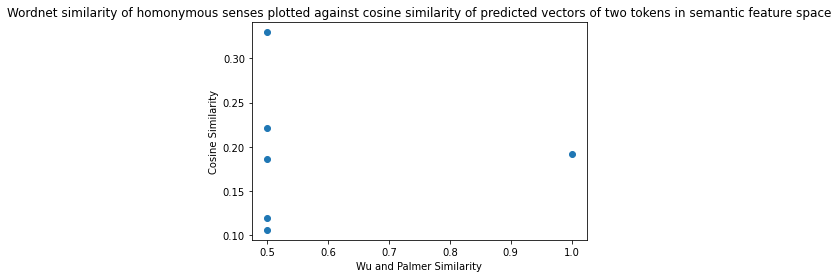

'\nWe have these values for a single word. we cant store them for the whole dataset because, \neven if we only have 1000 senses of a word,\n1000 choose 2 leaves us with almost 500K pairwise combinations of tokens.\n\n'

In [11]:
"""
Now what we need to do is go through each of the words and, 
using our model, predict the features in context for each of the tokens of that word.

We iterate through the stored sentenes containing that token.
- we find the word in the sentence, 
- we store its wordnet sense
- and we predict its features. 

"""




#tagged_sents = semcor.tagged_sents( tag = ' sem ' )



all_sense_similarities = []

for word, sentence_ids in word_index.items():
    wordform_data = []

#     print(word)
#     print(sentence_ids)
    for sentence_id in sentence_ids:
        sentence_string = ' '.join(semcor_indexer[sentence_id]).lower()
        
        # the list returned by nltk is indexed one behind the official id of the sentence in semcor
        tagged_sentence = tagged_sents[sentence_id - 1]
        #print(tagged_sentence)
        
        
        for chunk in tagged_sentence:

            chunk_string = ' '.join(chunk.leaves())
            
            """
            if we find the word we're looking for in this chunk,
            and that chunk has a wordnet sense (function words dont)
            then scoop it up

            """            
            if chunk_string.lower() == word:
                #print("found %s" % word)
                #print(chunk.label())

                #wn_lemma = cunk.label()
                if isinstance(chunk.label() , wordnet.Lemma):
                    try:
                        prediction = model.predict_in_context(word, sentence_string, bert)

                        row = {
                            "wordform": word,
                            "wn_lemma": chunk.label(),
                            "semcor_id": sentence_id,
                            "prediction": prediction,
                        }
                        wordform_data.append(row)
                    except:
                        None
        
        #print(row)
        #raise Exception('not done')
    
    
    """

    When we have all of these for a single wordform, we construct a dataset structured like this

        wn_lemma predicted_feature_vector

    First we should note how many senses there are, and how many tokens of each sense

    """
    df = pd.DataFrame.from_records(wordform_data, columns = ["wordform", "wn_lemma", "semcor_id", "prediction"])  
    #print(df)
    
    num_senses = df['wn_lemma'].value_counts()
    #print(counts)

    """

    then we calculate the pairwise distances between all of the vectors, only counting one pair one time

    """
    vals_for_this_token = []
    
    # pop the first token off the list
    num_toks = len(df)
    for i in range(0,num_toks):
        # compare it with each of the other tokens
        # dont have to compare to any earlier
        for j in range(i+1,num_toks):

            #print(df.iloc[i])
            #print(df.iloc[j])
            
            # calculate cosine similarity between the two vectors
            cos_sim = 1 - cosine(df.iloc[i].prediction, df.iloc[j].prediction)
            
            # and wu palmer similarity between the two wn lemmas
            synset1 = df.iloc[i].wn_lemma.synset()
            synset2 = df.iloc[j].wn_lemma.synset()
            wup_sim = synset1.wup_similarity(synset2)
            
            # if we can't compute a distance for these senses / recognize them, discard
            if type(wup_sim) == float:
                # store this data point into a list
                vals_for_this_token.append((cos_sim, wup_sim))
                all_sense_similarities.append((cos_sim, wup_sim))
    
    # store the values for this word into a dataframe
    
    sense_similarities = pd.DataFrame.from_records(vals_for_this_token, columns = ["cos_sim", "wup_sim"])
    # print(sense_similarities)
    
    
    if len(sense_similarities) > 1 :
        print(word)
        
        cos_sims = sense_similarities['cos_sim']
        wup_sims = sense_similarities['wup_sim']
    
        corr, p = pearsonr(cos_sims, wup_sims )
        print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

        corr, p = spearmanr(cos_sims, wup_sims )
        print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))

        plt.scatter(wup_sims, cos_sims)
        plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
        plt.xlabel("Wu and Palmer Similarity")
        plt.ylabel("Cosine Similarity")
        plt.show()


        print()
        print()
        
"""
We have these values for a single word. we cant store them for the whole dataset because, 
even if we only have 1000 senses of a word,
1000 choose 2 leaves us with almost 500K pairwise combinations of tokens.

"""


In [ ]:
"""

some choices here: we are looking at correlations for multi-prototype model
including monosemous words
"""

all_sense_similarities = pd.DataFrame.from_records(all_sense_similarities, columns = ["cos_sim", "wup_sim"])

cos_sims = all_sense_similarities['cos_sim']
wup_sims = all_sense_similarities['wup_sim']

corr, p = pearsonr(cos_sims, wup_sims )
print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

corr, p = spearmanr(cos_sims, wup_sims )
print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))

plt.scatter(wup_sims, cos_sims)
plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
plt.xlabel("Wu and Palmer Similarity")
plt.ylabel("Cosine Similarity")
plt.show()

In [ ]:

# multi_model_predictions = []



# def pluralize(string):
#     if string == 'mouse':
#         return 'mice'
#     else:
#         return string + 's'


    

# models = {"multi_prototype_model_preds": multi_model,
#          #"single_prototype_model_preds": single_model,
#          #"glove_model_preds": glove_model
#          }
# for label, model in models.items():
#     predictions = []        
    
#     for index, row in df.iterrows():
#         if index % 1000 == 0:
#             print("processed %s tokens" % index)
        
#         #print(df.semcor_token)
#         #print(row.sentence_id)
#         sentence = semcor_indexer.get_object(row.sentence_id)
#         #print(sentence)
#         #print(row.semcor_token)
#         prediction = model.predict_in_context(row.semcor_token, sentence, bert)
#         multi_model_predictions.append(prediction)
        
#         #singular = row.semcor_token
#         #plural = engine.plural(singular)

#         try:
#             predicted_vector = model.predict_in_context(row.semcor_token, sentence, bert)
#         except:
#             predicted_vector = model.predict_in_context(row.semcor_token, sentence, bert)


#         predictions.append(predicted_vector)

#     df[label] = predictions

# df
    
# df['multi_prototype_model_predictions'] = predictions

For each pair of tokens of the same lemma, we calculate
    (1) the distance between those two senses in wordnet
    (2) the cosine / jaqqard distance between the two predicted feature vectors.
and store these into a list, along with the lemma.

In [ ]:
"""
this is the stupid way that takes ten decades. why don;t you try this again but smarter in the next cell
"""


# wup_sims = []
# cossine_sims = []

# for index, row in df.iterrows():
#     wordform = row.semcor_token
    
#     # select other examples of this token
#     othertokens = df[df.semcor_token == wordform]
#     # filter out the token itself
#     othertokens = othertokens[othertokens.index != index]
#     #print(othertokens)
    
#     for index, otherword in othertokens.iterrows():
#         # find the wordnet distance between these two wordnet senses
#         synset1 = row.wn_lemma.synset()
#         synset2 = otherword.wn_lemma.synset()
        
#         wup_sim = synset1.wup_similarity(synset2)
#         wup_sims.append(wup_sim)
#         cossim = 1 - cosine(row.multi_prototype_model_preds, otherword.multi_prototype_model_preds)
#         #cossim = 1 - cosine(row.single_prototype_model_preds, otherword.single_prototype_model_preds)
#         cossine_sims.append(cossim)
#         #print(synset1)
#         #print(synset2)
#         #print(wup_sim)
#         #print(cossim)


In [ ]:
"""
same as above cell, but smarter. first we create a list of words in the corpus indexed to all the sentences containing that token.
"""



In [ ]:
# from math import isnan

# print(len(cossine_sims))
# print(len(wup_sims))

# for cs in cossine_sims:
#     if type(cs) != np.float64:
#         print(cs)
        
        
# # get rid of problematic nonetype rows for wu palmer similarity
# # in future I should figure out why they are problematic, giving none for similarity between lemmas


# zipped = list(zip(cossine_sims, wup_sims))
# new_cossine_sims = []
# new_wup_sims = []

# print(len(zipped))

# for index in range(0,len(zipped)):
#     if type(wup_sims[index]) == float:
#         new_cossine_sims.append(cossine_sims[index])
#         new_wup_sims.append(wup_sims[index])

Finally, we correlate the wordnet distance with the predicted features. 